# Survival Model Discussion

*Benchmarking different Survival libraries and models*

* * *

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from adjustText import adjust_text

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder

from lifelines.datasets import load_dd
from lifelines import CoxPHFitter

import torchtuples as tt
from pycox.models import LogisticHazard, DeepHitSingle
from pycox.evaluation import EvalSurv

from xgbse import XGBSEKaplanNeighbors, XGBSEBootstrapEstimator, XGBSEKaplanTree
from xgbse.converters import convert_data_to_xgb_format, convert_to_structured

from src.dd_column_cfg import id_col, drop_cols, cat_cols, num_cols, duration_col, event_col, target_cols

In [3]:
def evaluate_model():
    
    surv_avg = y_pred_surv.iloc[:prediction_horizon].mean(axis=0).mean()
    eval_obj = EvalSurv(y_pred_surv, np.array(test[duration_col].to_numpy()), np.array(test[event_col].to_numpy()), censor_surv='km')

    ctd = eval_obj.concordance_td('antolini')
    
    brier_grid = eval_obj.brier_score(t_eval_grid)[:prediction_horizon]
    brier_mean = np.mean(brier_grid)
    brier_1 = brier_grid.iloc[5]
    brier_2 = brier_grid.iloc[10]
    brier_3 = brier_grid.iloc[15]

    cols=['Model', 'Surv_Avg', 'CTD', 'Brier_Mean', 'Brier_5', 'Brier_10', 'Brier_15', 'Train_Time', 'Pred_Time']
    eval_df = pd.DataFrame([(model_desc, surv_avg, ctd, brier_mean, brier_1, brier_2, brier_3, train_time, pred_time)], columns=cols)
    
    return eval_df.round(3)

# Config

In [4]:
fast_run = False

sample = 500 if fast_run else None
epochs= 2 if fast_run else 50
xgbse_n_estimators = 2 if fast_run else 15
xgbse_neighbors= 2 if fast_run else 30

sample

In [5]:
prediction_horizon=20
t_eval_grid = np.array(range(1, prediction_horizon+1))
random_state=666
test_size=0.2

In [6]:
res_dict = {}
surv_dict = {}
mean_curve_dict = {}
surv_hor_dict = {}

# Data

In [7]:
data = load_dd()

data = data.reset_index().rename(columns={'index': id_col})
data.democracy = np.where(data.democracy=='Democracy', 1,0)

data.shape

(1808, 13)

In [8]:
data[cat_cols] = data[cat_cols].astype('category')

bin_cols = [n for n,col in data[cat_cols].items() if len(col.cat.categories) <= 2]
cat_cols = list(set(cat_cols) - set(bin_cols))

features = cat_cols + bin_cols + num_cols
col_order = num_cols + cat_cols + bin_cols + target_cols

# Train/Test Split

In [9]:
if sample is not None:
    data = data.sample(sample)

data.shape

(1808, 13)

In [10]:
data_train, data_test = train_test_split(data, test_size=0.2)

data_train.shape, data_test.shape

((1446, 13), (362, 13))

In [11]:
y_train_ids = data_train[id_col].to_list()
y_test_ids = data_test[id_col].to_list()

# Prepare X

In [12]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('target_cat', TargetEncoder())
])

transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
        ('passthrough', 'passthrough', bin_cols + target_cols),
        ('drop', 'drop', drop_cols + [id_col])
    ])

In [13]:
train = transformer.fit_transform(data_train, data_train[duration_col])
test = transformer.transform(data_test)

train = pd.DataFrame(train, columns=col_order)
test = pd.DataFrame(test, columns=col_order)

# Prepare Y

In [14]:
cuts = list(range(1, data[duration_col].max()+1))
cuts[:3], cuts[-3:]

([1, 2, 3], [45, 46, 47])

# CoxPH

In [15]:
model_desc = 'CoxPH'

In [16]:
cph = CoxPHFitter()

start = time.time()
cph.fit(train, duration_col=duration_col, event_col=event_col)
train_time = np.round(time.time()-start)

In [17]:
start = time.time()
y_pred_surv =  cph.predict_survival_function(test).round(3)
pred_time = np.round(time.time()-start)

eval_df = evaluate_model()
res_dict[model_desc] = eval_df

eval_df

,Model,Surv_Avg,CTD,Brier_Mean,Brier_5,Brier_10,Brier_15,Train_Time,Pred_Time
0,CoxPH,0.269,0.628,0.134,0.172,0.113,0.084,0.0,0.0


In [18]:
pred_df = y_pred_surv.T.copy()
pred_df[id_col] = y_test_ids
pred_df = pred_df.melt(id_vars=id_col, value_name='survival', var_name='t')
pred_df.t = pred_df.t + 1
pred_df['model'] = model_desc

surv_dict[model_desc] = pred_df.copy()
pred_df.shape

(15204, 4)

In [19]:
surv_hor_df = pd.DataFrame(y_pred_surv.iloc[prediction_horizon]).round(2)
surv_hor_df.columns = [f'survival_{model_desc}']
surv_hor_dict[model_desc] = surv_hor_df

In [20]:
pred_mean_df = pd.DataFrame(y_pred_surv.mean(axis=1), columns=['survival']).round(3).reset_index()
pred_mean_df.columns = ['t', f'survival_{model_desc}']
mean_curve_dict[model_desc] = pred_mean_df

# XGBSEBootstrapEstimator

In [21]:
model_desc = 'XGBSEBootstrapEstimator'

## Prepare Y

In [22]:
y_train_xgbse = convert_to_structured(train[duration_col], train[event_col])

## Model

In [23]:
base_estimator = XGBSEKaplanTree()
xgbse_model = XGBSEBootstrapEstimator(base_estimator, n_estimators=xgbse_n_estimators)

start = time.time()
xgbse_model.fit(train[features], y_train_xgbse, time_bins=cuts)
train_time = np.round(time.time()-start)

## Evaluate

In [24]:
start = time.time()
y_pred_surv = xgbse_model.predict(test[features]).T.round(3)
pred_time = np.round(time.time()-start)

eval_df = evaluate_model()
res_dict[model_desc] = eval_df

eval_df

,Model,Surv_Avg,CTD,Brier_Mean,Brier_5,Brier_10,Brier_15,Train_Time,Pred_Time
0,XGBSEBootstrapEstimator,0.239,0.672,0.131,0.158,0.115,0.09,1.0,0.0


In [25]:
pred_df = y_pred_surv.T.copy()
pred_df[id_col] = y_test_ids
pred_df = pred_df.melt(id_vars=id_col, value_name='survival', var_name='t')
pred_df['model'] = model_desc

surv_dict[model_desc] = pred_df.copy()

In [26]:
surv_hor_df = pd.DataFrame(y_pred_surv.iloc[prediction_horizon]).round(2)
surv_hor_df.columns = [f'survival_{model_desc}']
surv_hor_dict[model_desc] = surv_hor_df

In [27]:
pred_mean_df = pd.DataFrame(y_pred_surv.mean(axis=1), columns=['survival']).round(3).reset_index()
pred_mean_df.columns = ['t', f'survival_{model_desc}']

mean_curve_dict[model_desc] = pred_mean_df

# XGBSEKaplanNeighbors

In [28]:
model_desc = 'XGBSEKaplanNeighbors'

## Model

In [29]:
xgbse_model = XGBSEKaplanNeighbors(n_neighbors=xgbse_neighbors)

start = time.time()
xgbse_model.fit(train[features], y_train_xgbse, time_bins=cuts)
train_time = np.round(time.time()-start)

## Evaluate

In [30]:
start = time.time()
y_pred_surv = xgbse_model.predict(test[features]).T.round(3)
pred_time = np.round(time.time()-start)

eval_df = evaluate_model()
res_dict[model_desc] = eval_df

eval_df

,Model,Surv_Avg,CTD,Brier_Mean,Brier_5,Brier_10,Brier_15,Train_Time,Pred_Time
0,XGBSEKaplanNeighbors,0.229,0.679,0.133,0.158,0.115,0.091,30.0,0.0


In [31]:
pred_df = y_pred_surv.T.copy()
pred_df[id_col] = y_test_ids
pred_df = pred_df.melt(id_vars=id_col, value_name='survival', var_name='t')
pred_df['model'] = model_desc

surv_dict[model_desc] = pred_df.copy()

In [32]:
surv_hor_df = pd.DataFrame(y_pred_surv.iloc[prediction_horizon]).round(2)
surv_hor_df.columns = [f'survival_{model_desc}']
surv_hor_dict[model_desc] = surv_hor_df

In [33]:
pred_mean_df = pd.DataFrame(y_pred_surv.mean(axis=1), columns=['survival']).round(3).reset_index()
pred_mean_df.columns = ['t', f'survival_{model_desc}']

mean_curve_dict[model_desc] = pred_mean_df

# Logistic Hazard

In [34]:
model_desc = 'LogisticHazard'

In [35]:
num_nodes = [64, 64, 64]
batch_norm = True
dropout = 0.1
dropout_embedding = 0.1
batch_size = 256

In [36]:
categorical_transformer_cox = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=None, strategy='constant', fill_value='Unbekannt')),
    ('ordered_cat', OrdinalEncoder())
])

transformer_cox = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer_cox, cat_cols),
        ('passthrough', 'passthrough', bin_cols + target_cols),
        ('drop', 'drop', drop_cols + [id_col])
    ])

In [37]:
x_train_cox = transformer_cox.fit_transform(data_train)
x_train_cox_df = pd.DataFrame(x_train_cox, columns=col_order)
x_train_cox_df[cat_cols] = x_train_cox_df[cat_cols].astype('category')

x_test_cox = transformer_cox.transform(data_test)
x_test_cox_df = pd.DataFrame(x_test_cox, columns=col_order)
x_test_cox_df[cat_cols] = x_test_cox_df[cat_cols].replace({-1: 0})

In [38]:
emb_dict = {n: len(col.cat.categories) for n, col in x_train_cox_df[cat_cols].items()}
emb_sizes = [(c, min(20, (c + 1) // 2)) for _, c in emb_dict.items()]
emb_cols = emb_dict.keys()

num_embeddings = np.array([x[0] for x in emb_sizes])
embedding_dims = np.array([x[1] for x in emb_sizes])
vocab_size = np.sum(num_embeddings) + 1

embedding_dims, vocab_size

(array([ 3, 11,  3]), 34)

In [39]:
x_train_tup_cox = tt.tuplefy(np.array(x_train_cox_df[num_cols + bin_cols]).astype('float32'), 
                             np.array(x_train_cox_df[cat_cols]).astype('int64'))

x_test_tup_cox = tt.tuplefy(np.array(x_test_cox_df[num_cols + bin_cols]).astype('float32'), 
                        np.array(x_test_cox_df[cat_cols]).astype('int64'))

In [40]:
y_train_tup_cox = tt.tuplefy(np.array(data_train[duration_col]).astype('int64'), 
                         np.array(data_train[event_col]).astype('float32'))

y_test_tup_cox = tt.tuplefy(np.array(data_test[duration_col]).astype('int64'), 
                        np.array(data_test[event_col]).astype('float32'))

test_cox = (x_test_tup_cox, y_test_tup_cox)

In [41]:
net = tt.practical.MixedInputMLP(in_features=len(num_cols + bin_cols), 
                         num_embeddings=num_embeddings + 1,
                         embedding_dims=embedding_dims,
                         out_features=max(cuts)+1,
                         num_nodes=num_nodes, 
                         batch_norm=batch_norm, 
                         dropout=dropout, 
                         dropout_embedding=dropout_embedding)

model = LogisticHazard(net=net, optimizer=tt.optim.Adam(lr=0.01, weight_decay=0))

In [42]:
start = time.time()

history = model.fit(input=x_train_tup_cox, target=y_train_tup_cox, batch_size=batch_size, 
                    epochs=epochs, val_data=test_cox, verbose=False)

train_time = np.round(time.time()-start)

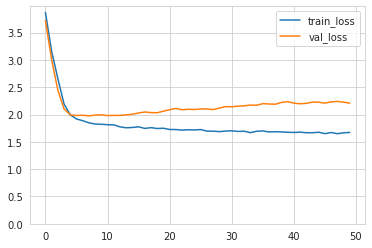

In [43]:
history.plot();
plt.ylim(0);

## Evaluate

In [44]:
start = time.time()
y_pred_surv =  model.predict_surv_df(x_test_tup_cox).round(3)
pred_time = np.round(time.time()-start)

eval_df = evaluate_model()
res_dict[model_desc] = eval_df

eval_df

,Model,Surv_Avg,CTD,Brier_Mean,Brier_5,Brier_10,Brier_15,Train_Time,Pred_Time
0,LogisticHazard,0.289,0.68,0.137,0.164,0.121,0.099,1.0,0.0


In [45]:
pred_df = y_pred_surv.T.copy()
pred_df[id_col] = y_test_ids
pred_df = pred_df.melt(id_vars=id_col, value_name='survival', var_name='t')
pred_df.t = pred_df.t + 1
pred_df['model'] = model_desc

surv_dict[model_desc] = pred_df.copy()
pred_df.shape

(17376, 4)

In [46]:
surv_hor_df = pd.DataFrame(y_pred_surv.iloc[prediction_horizon]).round(2)
surv_hor_df.columns = [f'survival_{model_desc}']
surv_hor_dict[model_desc] = surv_hor_df

In [47]:
pred_mean_df = pd.DataFrame(y_pred_surv.mean(axis=1), columns=['survival']).round(3).reset_index()
pred_mean_df.columns = ['t', f'survival_{model_desc}']
mean_curve_dict[model_desc] = pred_mean_df

# DeepHit

In [48]:
model_desc = 'DeepHit'

In [49]:
net = tt.practical.MixedInputMLP(in_features=len(num_cols + bin_cols), 
                         num_embeddings=num_embeddings + 1,
                         embedding_dims=embedding_dims,
                         out_features=max(cuts)+1,
                         num_nodes=num_nodes, 
                         batch_norm=batch_norm, 
                         dropout=dropout, 
                         dropout_embedding=dropout_embedding)

model = DeepHitSingle(net=net, optimizer=tt.optim.Adam(lr=0.01, weight_decay=0))

In [50]:
start = time.time()

history = model.fit(input=x_train_tup_cox, target=y_train_tup_cox, batch_size=batch_size, 
                    epochs=epochs, val_data=test_cox, verbose=False)

train_time = np.round(time.time()-start)

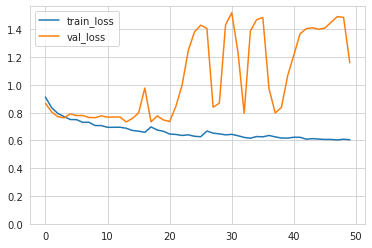

In [51]:
history.plot();
plt.ylim(0);

## Evaluate

In [52]:
start = time.time()
y_pred_surv =  model.predict_surv_df(x_test_tup_cox).round(3)
pred_time = np.round(time.time()-start)

eval_df = evaluate_model()
res_dict[model_desc] = eval_df

eval_df

,Model,Surv_Avg,CTD,Brier_Mean,Brier_5,Brier_10,Brier_15,Train_Time,Pred_Time
0,DeepHit,0.294,0.682,0.136,0.179,0.11,0.085,2.0,0.0


In [53]:
pred_df = y_pred_surv.T.copy()
pred_df[id_col] = y_test_ids
pred_df = pred_df.melt(id_vars=id_col, value_name='survival', var_name='t')
pred_df.t = pred_df.t + 1
pred_df['model'] = model_desc

surv_dict[model_desc] = pred_df.copy()

In [54]:
surv_hor_df = pd.DataFrame(y_pred_surv.iloc[prediction_horizon]).round(2)
surv_hor_df.columns = [f'survival_{model_desc}']
surv_hor_dict[model_desc] = surv_hor_df

In [55]:
pred_mean_df = pd.DataFrame(y_pred_surv.mean(axis=1), columns=['survival']).round(3).reset_index()
pred_mean_df.columns = ['t', f'survival_{model_desc}']
mean_curve_dict[model_desc] = pred_mean_df

# Compare

## Metrics

In [56]:
res_df = pd.concat(res_dict).reset_index(drop=True).sort_values('CTD', ascending=False).round(3)
res_df

,Model,Surv_Avg,CTD,Brier_Mean,Brier_5,Brier_10,Brier_15,Train_Time,Pred_Time
4,DeepHit,0.294,0.682,0.136,0.179,0.110,0.085,2.0,0.0
3,LogisticHazard,0.289,0.680,0.137,0.164,0.121,0.099,1.0,0.0
2,XGBSEKaplanNeighbors,0.229,0.679,0.133,0.158,0.115,0.091,30.0,0.0
1,XGBSEBootstrapEstimator,0.239,0.672,0.131,0.158,0.115,0.090,1.0,0.0
0,CoxPH,0.269,0.628,0.134,0.172,0.113,0.084,0.0,0.0


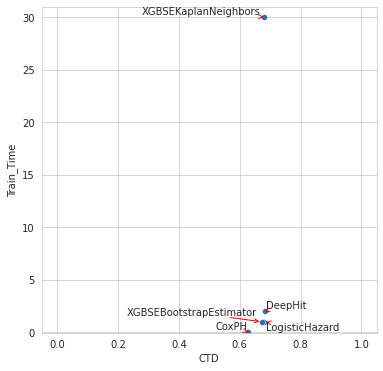

In [57]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='CTD', y='Train_Time', data=res_df)
plt.ylim(-0.05, res_df.Train_Time.max()+1)
plt.xlim(-0.05,1.05)

# Plot labels without collision
x = res_df.CTD.to_list()
y = res_df.Train_Time.to_list()
t = res_df.Model.to_list()
texts = [plt.text(x[i], y[i], t[i]) for i in range(len(x))]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'));

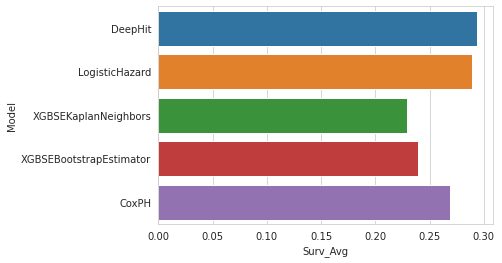

In [58]:
sns.barplot(data=res_df, x='Surv_Avg', y='Model');

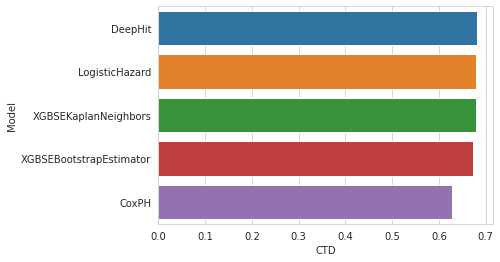

In [59]:
sns.barplot(data=res_df, x='CTD', y='Model');

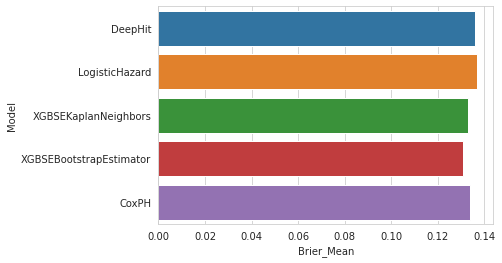

In [60]:
sns.barplot(data=res_df, x='Brier_Mean', y='Model');

## Durations

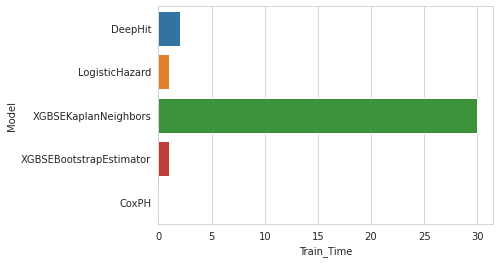

In [61]:
sns.barplot(data=res_df, x='Train_Time', y='Model');

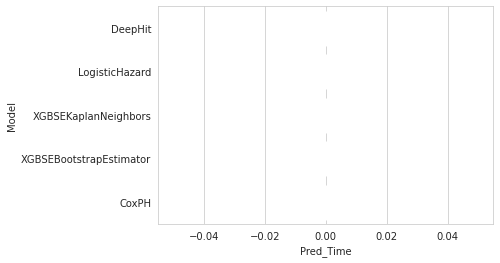

In [62]:
sns.barplot(data=res_df, x='Pred_Time', y='Model');

## Survival Distribution @ t max

In [63]:
surv_df = pd.concat(surv_dict, ignore_index=True)
surv_df = surv_df[surv_df.t <= prediction_horizon]

In [64]:
test[id_col] = y_test_ids

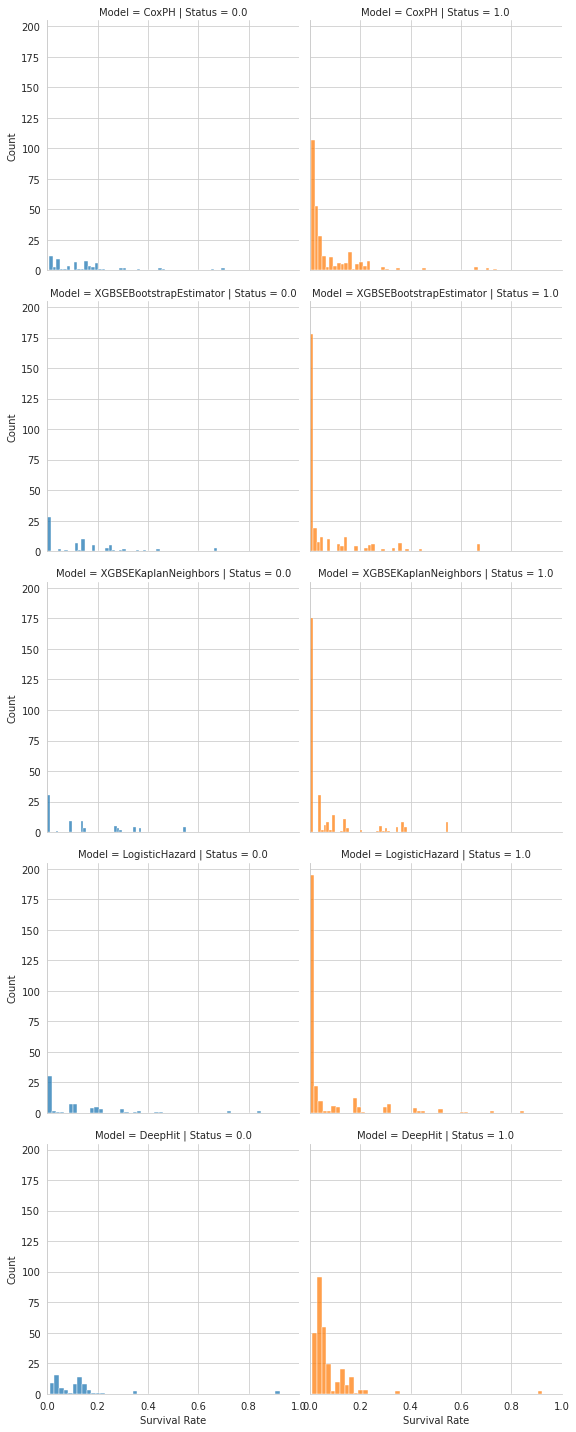

In [65]:
surv_t60_df = surv_df[surv_df.t==prediction_horizon]
surv_t60_df = surv_t60_df.merge(test[[id_col, event_col]])
surv_t60_df.columns = [id_col, 't', 'Survival Rate', 'Model', 'Status']

g = sns.FacetGrid(surv_t60_df, col="Status", row='Model', hue="Status", height=4)
g.map(sns.histplot, "Survival Rate", bins=50)
g.set(xlim=(0, 1));

## Survival Averages

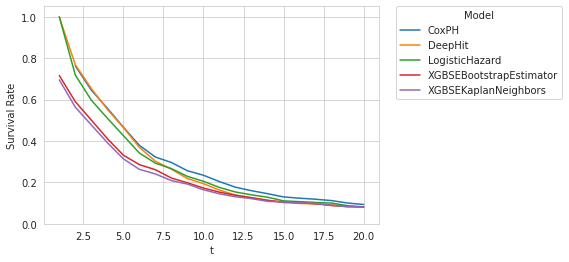

In [66]:
mean_curve_df = surv_df.groupby(['model', 't'], as_index=False).agg({'survival': 'mean'})
mean_curve_df = mean_curve_df.pivot(index='t', columns='model', values='survival').reset_index()

melt_df = mean_curve_df.melt(id_vars='t', var_name='Model', value_name='Survival Rate')
sns.lineplot(data=melt_df, x='t', y='Survival Rate', hue='Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Model')
plt.ylim(0,1.05);

## Survival Averages by Democracy

In [67]:
surv_df = surv_df.merge(data[[id_col, 'un_continent_name', 'regime', 'democracy']])
surv_df.shape

(35838, 7)

In [68]:
by_col = 'democracy'

In [69]:
df = surv_df.groupby(['model', by_col], as_index=False).agg({'survival': 'mean'})
df.pivot(index='model', columns=by_col, values='survival').round(2)

democracy,0,1
model,,
CoxPH,0.44,0.19
DeepHit,0.37,0.25
LogisticHazard,0.44,0.21
XGBSEBootstrapEstimator,0.40,0.15
XGBSEKaplanNeighbors,0.39,0.14


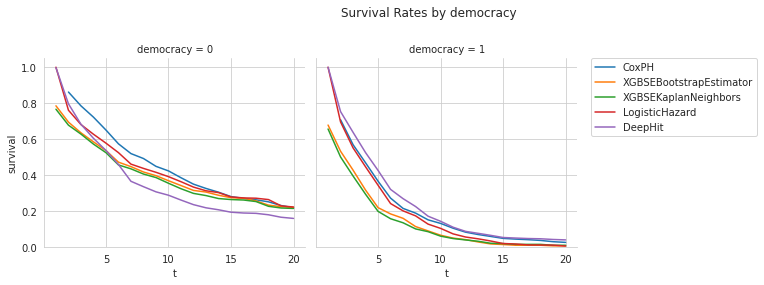

In [70]:
df = pd.DataFrame()

for k in surv_dict.keys():
    df_tmp = surv_df[surv_df.model==k].groupby(['t', by_col]).agg({'survival': 'mean'}).reset_index()
    df_tmp['model'] = k
    df = pd.concat([df, df_tmp], ignore_index=True)

g = sns.FacetGrid(data=df, col=by_col, col_wrap=3, height=4)
g.map(sns.lineplot, 't', 'survival', 'model')

g.fig.suptitle(f'Survival Rates by {by_col}')
g.fig.subplots_adjust(top=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1.05);

## Survival Averages by Continent

In [71]:
by_col = 'un_continent_name'

In [72]:
df = surv_df.groupby(['model', by_col], as_index=False).agg({'survival': 'mean'})
df.pivot(index='model', columns=by_col, values='survival').round(2)

un_continent_name,Africa,Americas,Asia,Europe,Oceania
model,,,,,
CoxPH,0.38,0.25,0.36,0.19,0.20
DeepHit,0.32,0.27,0.35,0.26,0.25
LogisticHazard,0.39,0.27,0.36,0.21,0.23
XGBSEBootstrapEstimator,0.35,0.22,0.32,0.15,0.17
XGBSEKaplanNeighbors,0.35,0.22,0.31,0.13,0.16


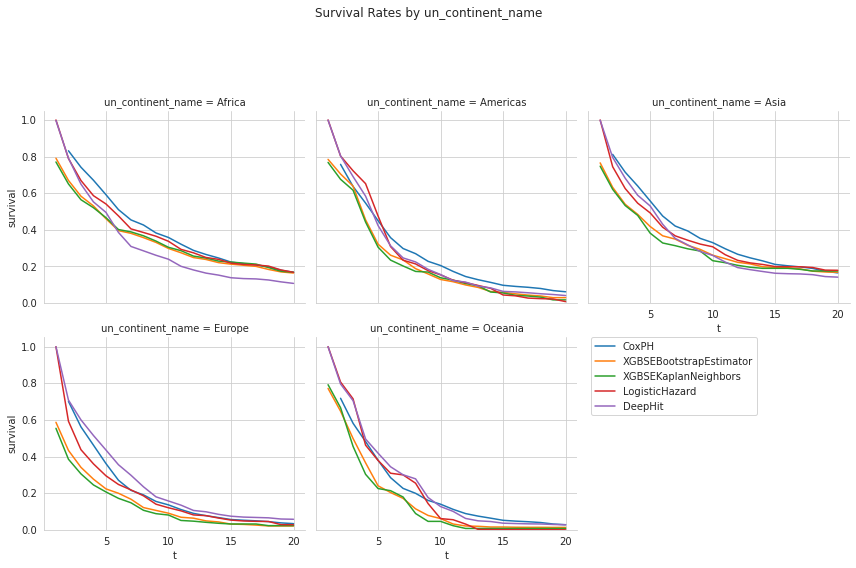

In [73]:
df = pd.DataFrame()

for k in surv_dict.keys():
    df_tmp = surv_df[surv_df.model==k].groupby(['t', by_col]).agg({'survival': 'mean'}).reset_index()
    df_tmp['model'] = k
    df = pd.concat([df, df_tmp], ignore_index=True)

g = sns.FacetGrid(data=df, col=by_col, col_wrap=3, height=4)
g.map(sns.lineplot, 't', 'survival', 'model')

g.fig.suptitle(f'Survival Rates by {by_col}')
g.fig.subplots_adjust(top=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1.05);

## Survival Averages by Regime

In [74]:
by_col='regime'

In [75]:
df = surv_df.groupby(['model', by_col], as_index=False).agg({'survival': 'mean'})
df.pivot(index='model', columns=by_col, values='survival').round(2)

regime,Civilian Dict,Military Dict,Mixed Dem,Monarchy,Parliamentary Dem,Presidential Dem
model,,,,,,
CoxPH,0.45,0.37,0.15,0.81,0.21,0.19
DeepHit,0.38,0.33,0.24,0.53,0.27,0.24
LogisticHazard,0.48,0.34,0.16,0.76,0.23,0.21
XGBSEBootstrapEstimator,0.43,0.31,0.09,0.82,0.17,0.16
XGBSEKaplanNeighbors,0.45,0.29,0.11,0.58,0.16,0.13


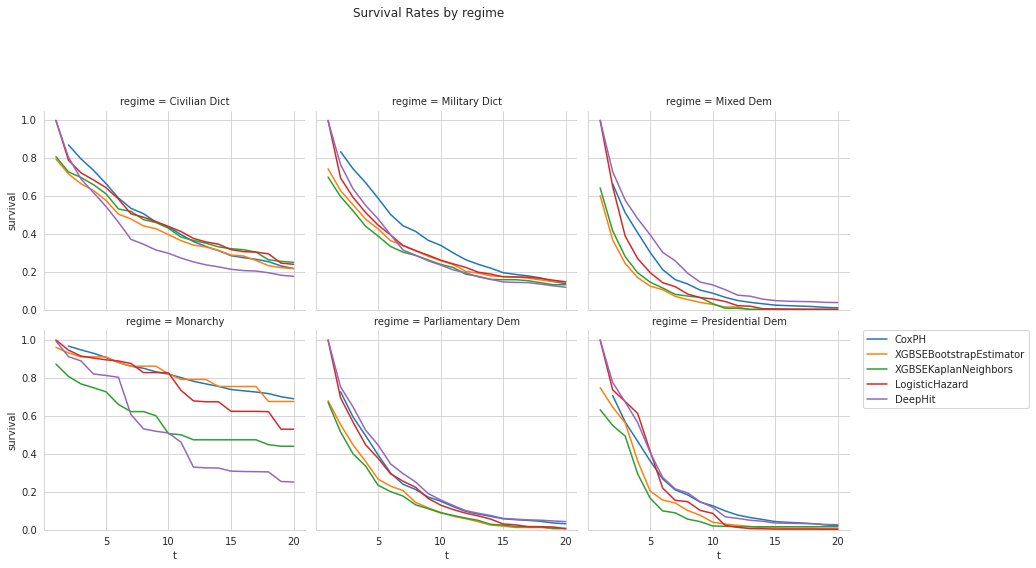

In [76]:
df = pd.DataFrame()

for k in surv_dict.keys():
    df_tmp = surv_df[surv_df.model==k].groupby(['t', by_col]).agg({'survival': 'mean'}).reset_index()
    df_tmp['model'] = k
    df = pd.concat([df, df_tmp], ignore_index=True)

g = sns.FacetGrid(data=df, col=by_col, col_wrap=3, height=4)
g.map(sns.lineplot, 't', 'survival', 'model')

g.fig.suptitle(f'Survival Rates by {by_col}')
g.fig.subplots_adjust(top=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1.05);

## Survival by Continent & Democracy 

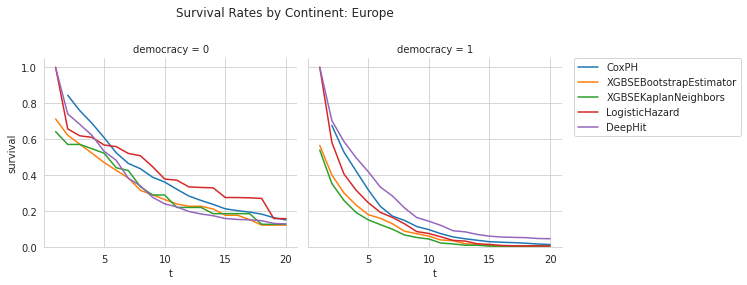

In [77]:
df = pd.DataFrame()
continent = 'Europe'

for k in surv_dict.keys():
    df_tmp = surv_df[(surv_df.model==k) & (surv_df.un_continent_name==continent)].groupby(['t', 'democracy']).agg({'survival': 'mean'}).reset_index()
    df_tmp['model'] = k
    df = pd.concat([df, df_tmp], ignore_index=True)
    
g = sns.FacetGrid(df, col='democracy', height=4)
g.map(sns.lineplot, 't', 'survival', 'model')
g.fig.suptitle(f'Survival Rates by Continent: {continent}')
g.fig.subplots_adjust(top=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1.05);

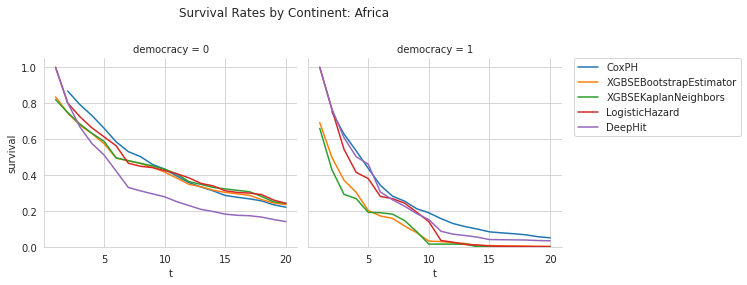

In [78]:
df = pd.DataFrame()
continent = 'Africa'

for k in surv_dict.keys():
    df_tmp = surv_df[(surv_df.model==k) & (surv_df.un_continent_name==continent)].groupby(['t', 'democracy']).agg({'survival': 'mean'}).reset_index()
    df_tmp['model'] = k
    df = pd.concat([df, df_tmp], ignore_index=True)
    
g = sns.FacetGrid(df, col='democracy', height=4)
g.map(sns.lineplot, 't', 'survival', 'model')
g.fig.suptitle(f'Survival Rates by Continent: {continent}')
g.fig.subplots_adjust(top=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1.05);